#**Building a Gen AI RAG Chatbot from Scratch**


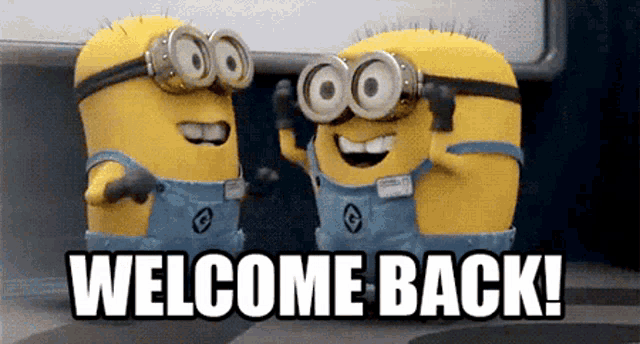

##Day 2 Recap:

Yesterday, we delved deeper into building our RAG chatbot. Here’s a quick reminder of what we covered:

**Loading Documents:** We learned how to load and preprocess documents using the TextLoader from LangChain to make our chatbot more knowledgeable.<br>
**Vector Stores:** We discussed how to create and manage a vector store with Chroma, allowing our chatbot to retrieve relevant documents efficiently.<br>
**Embeddings:** We used Hugging Face embeddings to convert our text into vector representations that the chatbot can understand.<br>

Today, we will enhance our chatbot by integrating it into a user-friendly interface using Streamlit, allowing for a more interactive experience!

##**<font color='Navy-Blue'>Day 3: Making a UI for our Chatbot using Streamlit</font>**

In this session, we will learn how to create a user-friendly interface for our RAG chatbot using **Streamlit**. We will also explore **ngrok** to expose our local Streamlit application to the internet.


##**Streamlit:**<br>

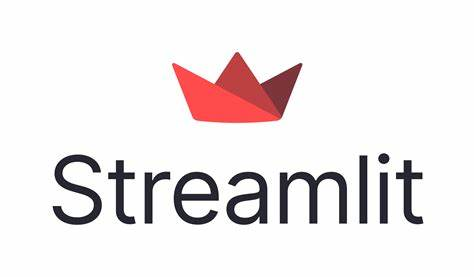
### Overview:
**Streamlit** is an open-source frontend framework specifically designed for machine learning and data science projects. It allows us to build interactive web applications quickly and with minimal coding. With Streamlit, we can turn data scripts into shareable web apps in a few minutes.
### Why Streamlit?
- **Simplicity:** Write your app in pure Python.
- **Interactivity:** Add widgets like sliders, buttons, and text inputs to make your app interactive.
- **Real-time updates:** The app reruns with every interaction, reflecting changes instantly.



#**nGrok** <br>
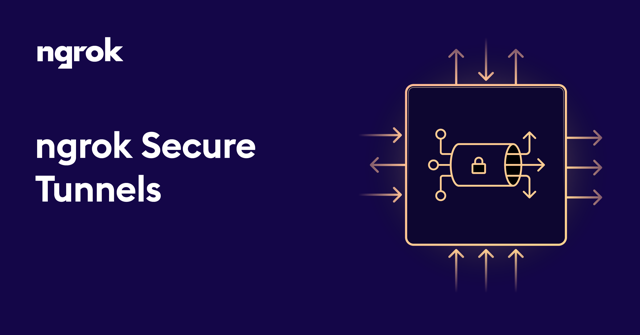

**ngrok** is a tool that creates secure tunnels to your localhost, allowing us to expose our local application to the internet. This is particularly useful for sharing your app with others without deploying it on a web server. We'll use it to deploy our streamlit app directly from Colab.


# What is tunneling? 🤔

Tunneling is a method of securely sending data from one network to another over a public network, such as the internet. It involves encapsulating or "tunneling" private network traffic inside another protocol or transport system, enabling that traffic to pass securely through a public or less secure network.

# **Lets Start!!**

**Step 1: Install the necessary libraries**

In [ ]:
!pip install langchain chromadb pypdf langchain_community sentence_transformers langchain_huggingface pyngrok streamlit langchain-groq


# Now that we understand the purposes of Streamlit and ngrok, let’s create a chat interface that stores chat history. We will use ngrok to establish a tunnel between our Google Colab environment and an external endpoint, allowing us to expose a URL for others to access our chat application.

Steps to follow:
1)Ngrok by deafault only executes a single file so we will to create a .py file of our notebook code

In [4]:

 #This exports all content in this to an app.py file which ngrok will use to run the app
%%writefile app.py
import os
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import TextLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_groq import ChatGroq
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
import streamlit as st

# Define constants
GROQ_API_KEY = ""  # Set your Groq API key here
PERSIST_DIRECTORY = "/content/chroma_db/"
folder_path="/content/data"
DOCUMENT_PATH = "/content/data/2307.pdf"  # Make sure this path is correct
# Here we define the title for our page or chatbot interface
st.title("RAG Chatbot Interface")

# Remove caching from this function
def load_or_create_vector_store(texts, embeddings):
    """Load or create a new Chroma vector store."""
    if os.path.exists(PERSIST_DIRECTORY):
        return Chroma(persist_directory=PERSIST_DIRECTORY, embedding_function=embeddings)

    return Chroma.from_documents(texts, embeddings, persist_directory=PERSIST_DIRECTORY)

def load_documents(document_path):
    """Load and split documents."""
    #  use text loader for loading csv or txt files
    all_texts = []  # To store the texts from all PDFs
    # Iterate over each file in the folder
    for filename in os.listdir(folder_path):
        # Only process files that end with .pdf
        if filename.endswith(".pdf"):
            file_path = os.path.join(folder_path, filename)
            loader = PyPDFLoader(file_path)  # Load the individual PDF
            documents = loader.load()  # Load documents from the PDF

            # Split the loaded documents into smaller chunks
            text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=1000,
                chunk_overlap=200,
                length_function=len,
                separators=["\n\n", "\n", " ", ""]
            )
            texts = text_splitter.split_documents(documents)
            all_texts.extend(texts)
    return all_texts
# Load documents and create embeddings
loading_message = st.empty()  # Create an empty placeholder for the loading message
loading_message.text("Loading documents and setting up embeddings...")  # Set the initial loading message

texts = load_documents(DOCUMENT_PATH)
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/msmarco-distilbert-base-v4")
db = load_or_create_vector_store(texts, embeddings)
db.persist()

# Clear the loading message
loading_message.empty()  # Remove the loading message

# Set up the language model with the API key
llm = ChatGroq(model="llama-3.1-70b-versatile", api_key=GROQ_API_KEY)  # Pass the API key here

# Define the prompt template
template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
Answer: """
QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"], template=template)

# Set up the RAG pipeline
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=db.as_retriever(),
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

# Initialize chat history
if "messages" not in st.session_state:
    st.session_state.messages = []

# Display chat messages from history on app rerun
for message in st.session_state.messages:
    with st.chat_message(message["role"]):
        st.markdown(message["content"])

# Accept user input
if prompt := st.chat_input("What is up?"):
    # Add user message to chat history
    st.session_state.messages.append({"role": "user", "content": prompt})
    # Display user message in chat message container
    with st.chat_message("user"):
        st.markdown(prompt)

    # Get the assistant's response
    response = qa_chain({"query": prompt})  # Use the prompt to get the response
    st.session_state.messages.append({"role": "assistant", "content": response['result']})

    # Display assistant response in chat message container
    with st.chat_message("assistant"):
        st.markdown(response['result'])


Writing app.py


**Running the App with ngrok**<br>
How to get Auth Token for ngrok

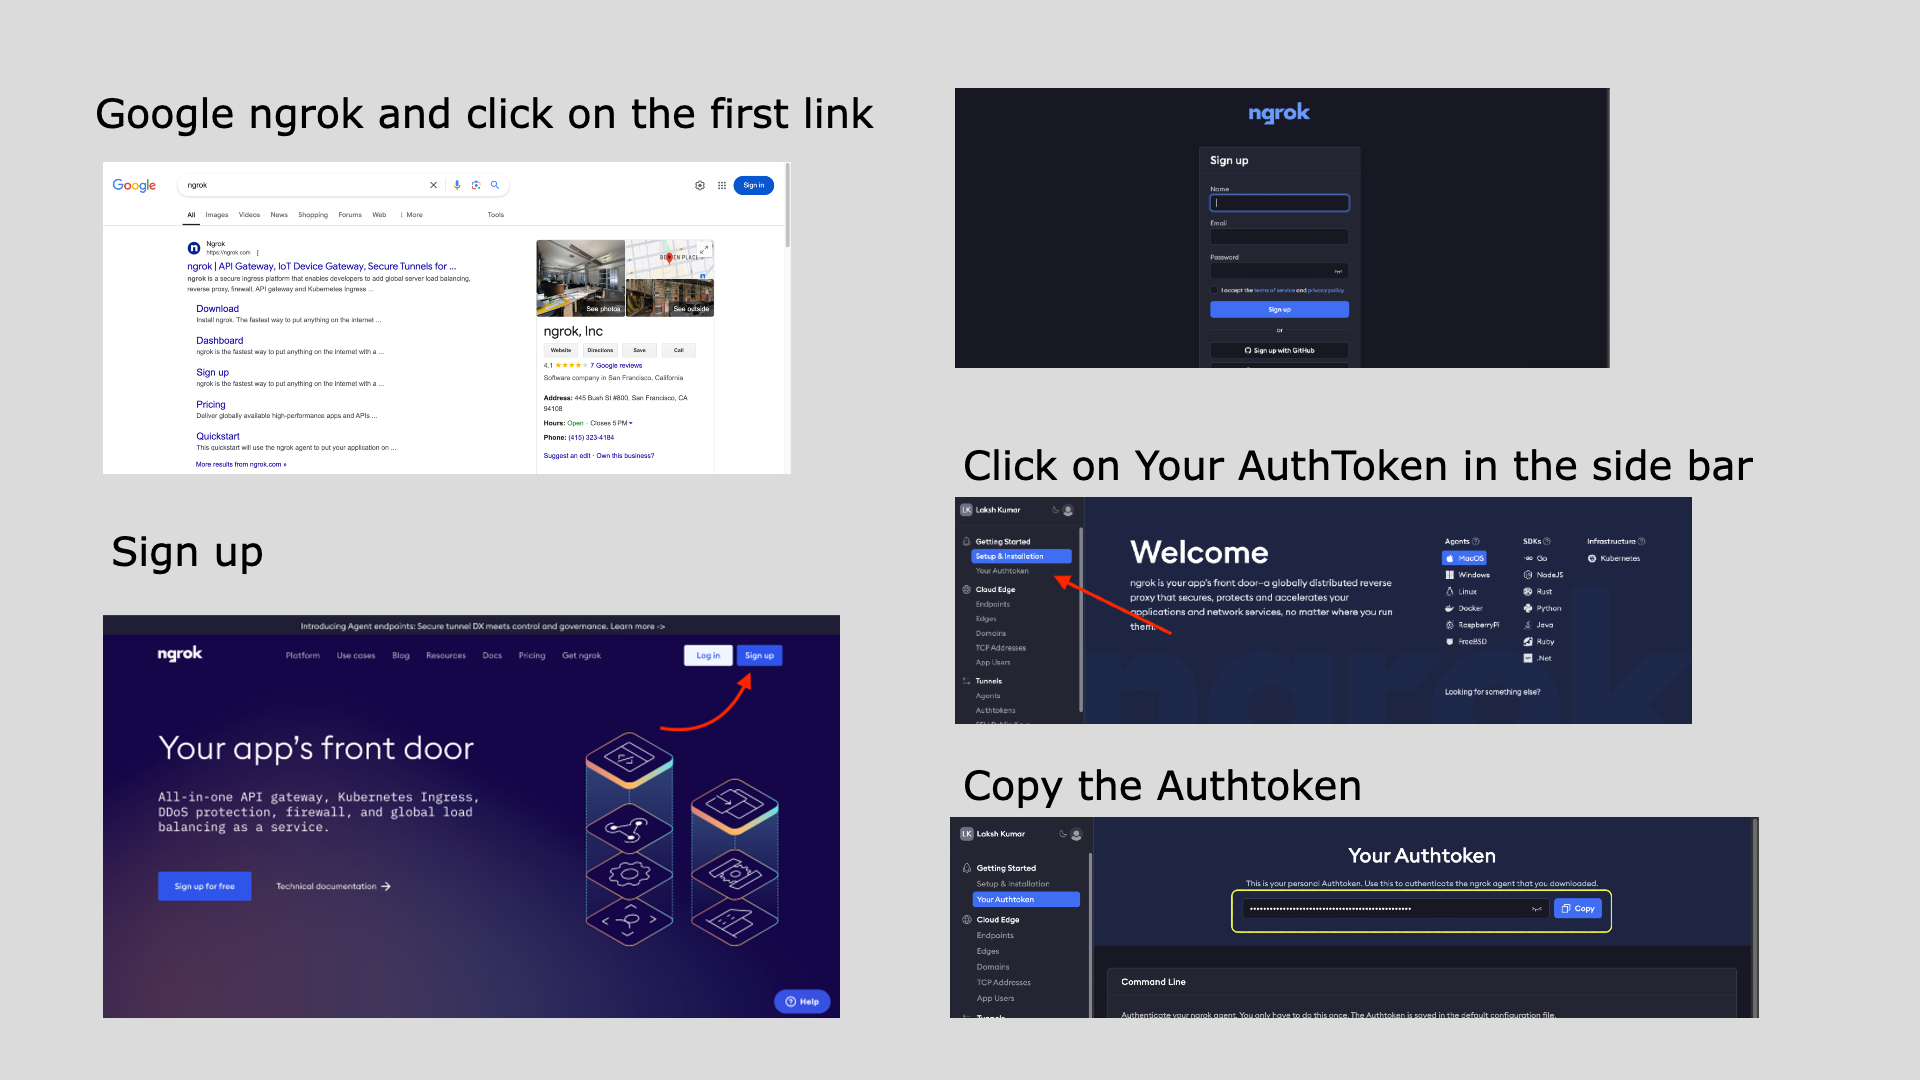

In [5]:
from pyngrok import ngrok

# Set authentication token if you haven't already done so
ngrok.set_auth_token("")

# Start Streamlit server on a specific port
!nohup streamlit run app.py --server.port 5011 &

# Start ngrok tunnel to expose the Streamlit server
ngrok_tunnel = ngrok.connect(addr='5011', proto='http', bind_tls=True)

# Print the URL of the ngrok tunnel
print(' * Tunnel URL:', ngrok_tunnel.public_url)

nohup: appending output to 'nohup.out'
 * Tunnel URL: https://17b3-35-247-9-37.ngrok-free.app


#**And Thats it**

Thank you for joining the workshop! We hope you all enjoyed the sessions and learned valuable skills during last three days.

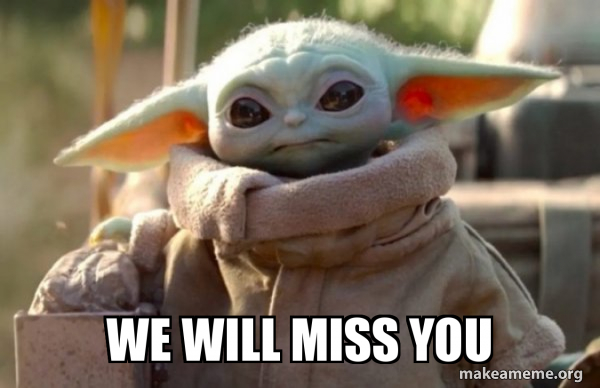

#**Until Next Time**